In [3]:
from analysis_scripts.onfly_decon_codestacks import *
import cv2
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

In [4]:
niter = 10
md_path = '/hybedata/Images/Maeve/BMDM_FISH/3T3_TNFa_probe_check_of_BMDM_probeset_2020Feb21/'
k = 1
zstart = 1
zskip = 2
zmax = 30
out_path = '/hybedata/Images/Maeve/BMDM_FISH/3T3_TNFa_probe_check_of_BMDM_probeset_2020Feb21/'
use_gpu = 1
ncpu = 1
tforms_path = '/hybedata/Images/Maeve/BMDM_FISH/3T3_TNFa_probe_check_of_BMDM_probeset_2020Feb21/results/tforms.pkl'
cword_config = 'seqfish_config_bmdm'
global_kernel = (2,2,0)
global_blur = (0.9,0.9,0)
psf_map = {'Orange': orange_psf, 'FarRed': farred_psf, 'Green': green_psf}
seqfish_config = importlib.import_module(cword_config)
nbits = seqfish_config.nbits

In [5]:
md = Metadata(md_path)

In [6]:
bitmap = seqfish_config.bitmap

In [7]:
good_positions = pickle.load(open(tforms_path, 'rb'))['good']

In [93]:
poses = md.image_table.Position.unique()
pos = poses[0]
pos_md =  md.image_table[md.image_table.Position==pos]
acqs = pos_md.acq.unique()
acq = acqs[0]
channels = pos_md[pos_md.acq==acq].Channel.unique()
channel = channels[0]
img = np.average(md.stkread(Position=pos,Channel=channel,acq=acq),axis=2)

opening img_Pos0_000000031_000000000_FarRed_000_031.tif

In [99]:
kernel_size = 5
if kernel_size%2==0:
    kernel_size = kernel_size+1
kernel = np.ones((kernel_size,kernel_size))
kernel[int(kernel_size/2),int(kernel_size/2)] = 0
kernel = kernel/np.sum(kernel)
bkg = cv2.filter2D(img,-1,kernel)

In [100]:
kernel

array([[0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667],
       [0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667],
       [0.04166667, 0.04166667, 0.        , 0.04166667, 0.04166667],
       [0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667],
       [0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667]])

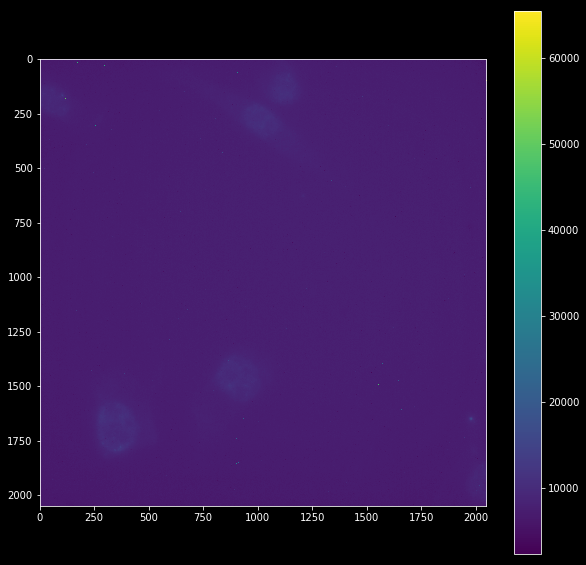

In [101]:
plt.figure(figsize=[10,10])
plt.imshow(img)
plt.colorbar()
plt.show()

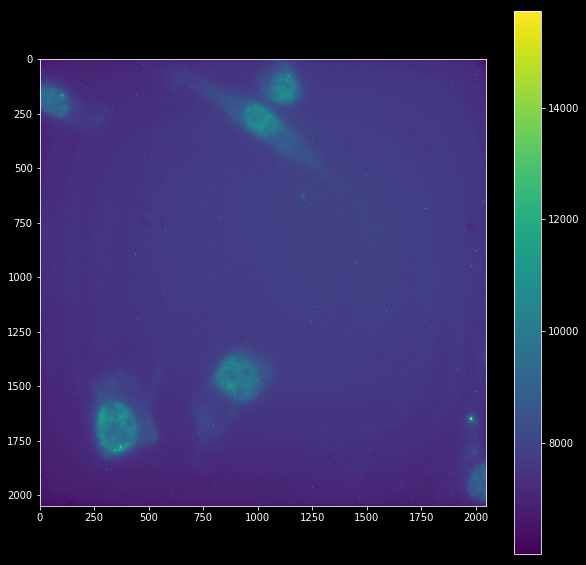

In [102]:
plt.figure(figsize=[10,10])
plt.imshow(bkg)
plt.colorbar()
plt.show()

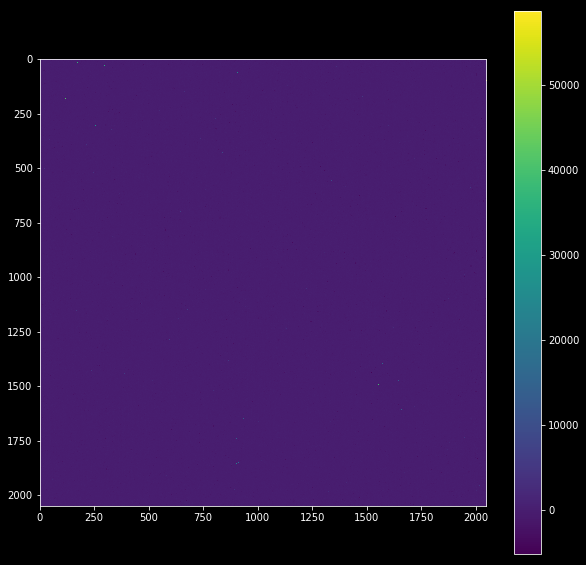

In [103]:
plt.figure(figsize=[10,10])
temp = img-bkg
plt.imshow(temp)
plt.colorbar()
plt.show()

opening img_Pos1_000000031_000000000_FarRed_000_031.tif

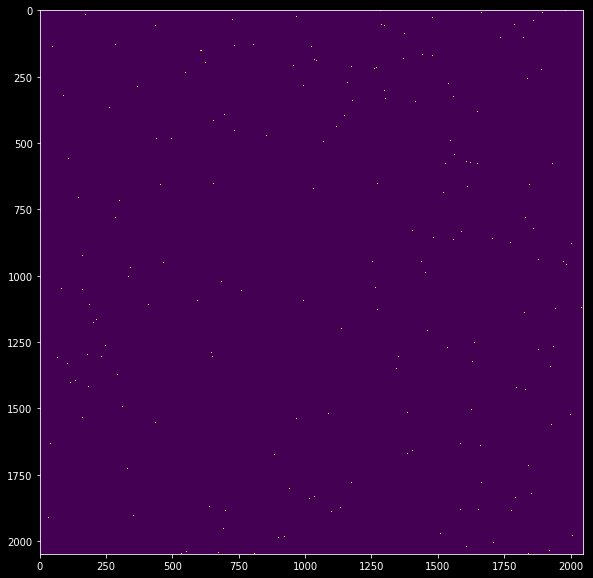

In [121]:
kernel_size = 5
if kernel_size%2==0:
    kernel_size = kernel_size+1
kernel = np.ones((kernel_size,kernel_size))
kernel[int(kernel_size/2),int(kernel_size/2)] = 0
kernel = kernel/np.sum(kernel)
poses = md.image_table.Position.unique()
pos = poses[1]
pos_md =  md.image_table[md.image_table.Position==pos]
acqs = pos_md.acq.unique()
acq = acqs[0]
channels = pos_md[pos_md.acq==acq].Channel.unique()
channel = channels[0]
img = np.average(md.stkread(Position=pos,Channel=channel,acq=acq),axis=2)
bkg = cv2.filter2D(img,-1,kernel)
plt.figure(figsize=[10,10])
temp = img/bkg
avg = np.average(temp)
std = np.std(temp)
plt.imshow(temp>(avg+(2*std)))
plt.show()

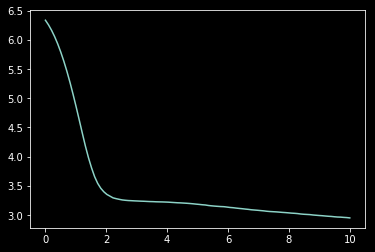

In [109]:
X = np.linspace(0,10,100)
avg = np.average(temp)
std = np.std(temp)
y = np.array([len(np.where(temp>(avg+(i*std)))[0]) for i in X])
Y = np.log10(y+1)
plt.plot(X,Y)
plt.show()

 [████████████████████████████████████████████████████████████] 5/5 [03:16<01:08, 39.19s/it]

opening img_Pos19_000000031_000000000_DeepBlue_000_031.tif

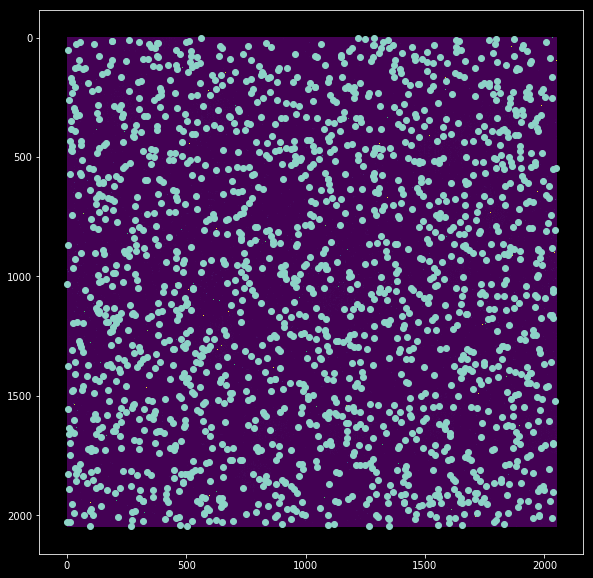

In [187]:
from ipypb import ipb
import cv2
import random
from skimage.filters import threshold_otsu
"""
Finding Hot Pixels
"""
def find_hot_pixels(md,n_pos=5,std_thresh=3,n_acqs=5,kernel_size=3):
    if kernel_size%2==0:
        kernel_size = kernel_size+1
    kernel = np.ones((kernel_size,kernel_size))
    kernel[int(kernel_size/2),int(kernel_size/2)] = 0
    kernel = kernel/np.sum(kernel)
    X = []
    Y = []
    poses = md.image_table.Position.unique()
    hot_pixel_dict = {}
    if len(poses)>n_pos:
        poses = random.sample(list(poses),n_pos)
    for pos in ipb(poses):
        pos_md =  md.image_table[md.image_table.Position==pos]
        acqs = pos_md.acq.unique()
        if len(acqs)>n_acqs:
            acqs = random.sample(list(acqs),n_acqs)
        for acq in acqs:
            hot_pixel_dict[acq] = {}
            channels = pos_md[pos_md.acq==acq].Channel.unique()
            for channel in channels:
                img = np.average(md.stkread(Position=pos,Channel=channel,acq=acq),axis=2)
                bkg_sub = img-cv2.filter2D(img,-1,kernel)
                avg = np.average(bkg_sub)
                std = np.std(bkg_sub)
                thresh = (avg+(std_thresh*std))
                loc = np.where(bkg_sub>thresh)
                X.extend(loc[0])
                Y.extend(loc[1])
    img = np.histogram2d(X,Y,bins=2048,range=[[0,2048],[0,2048]])[0]
#     avg = np.average(img)
#     std = np.std(img)
#     x = range(1,n_imgs)
#     y = np.array([len(np.where(img>(avg+(i*std)))[0]) for i in ipb(x)])
#     y = np.log10(y)
#     y = y[:-1]-y[1:]
#     n = X[np.where(y==y.max())[0][0]+2]
#     loc = np.where(img>avg+(n*std))
    loc = np.where(img>threshold_otsu(img))
    return img,loc,X,Y
img,loc,X,Y = find_hot_pixels(md)
plt.figure(figsize=[10,10])
plt.imshow(img)
plt.scatter(loc[0],loc[1])
plt.show()

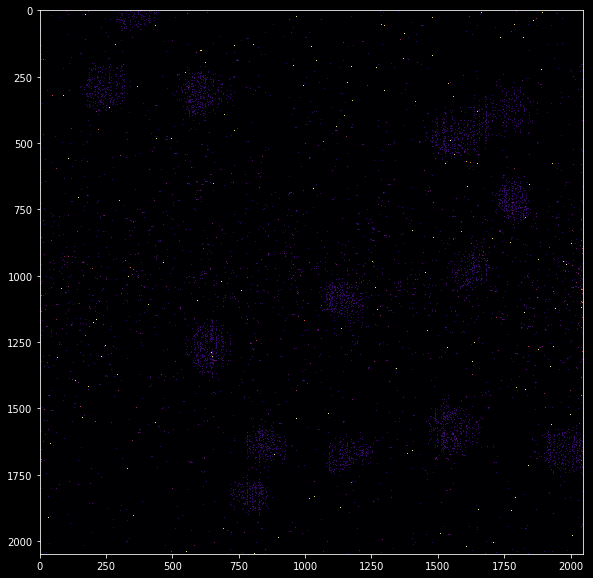

In [188]:
plt.figure(figsize=[10,10])
plt.imshow(np.log10(img+1),cmap='inferno')
plt.show()

In [ ]:
plt.hist(img.ravel())

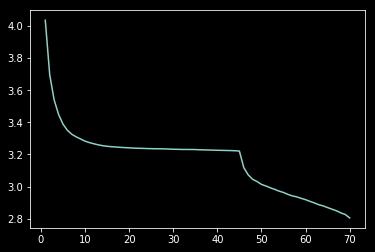

In [189]:
X = range(1,int(np.max(img.ravel())))
y = np.array([len(np.where(img>i)[0]) for i in X])
Y = np.log10(y+1)
plt.plot(X,Y)
plt.show()

In [199]:
img.max()

71.0

 [████████████████████████████████████████████████████████████] 47/47 [00:01<00:00, 0.03s/it]

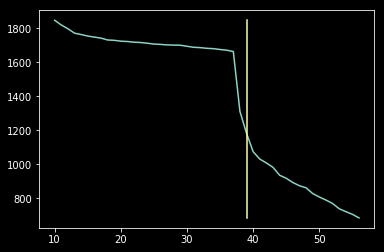

In [214]:
avg = np.average(img)
std = np.std(img)
x = range(10,int((int(img.max())-avg)/std))
y = np.array([len(np.where(img>(avg+(i*std)))[0]) for i in ipb(x)])
plt.plot(x,y)
plt.plot([n,n],[y.min(),y.max()])
plt.show()

 [████████████████████████████████████████████████████████████] 47/47 [00:01<00:00, 0.03s/it]

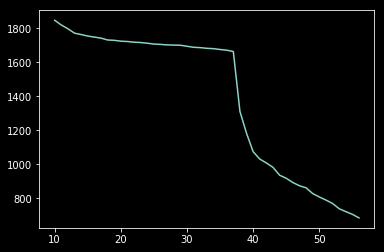

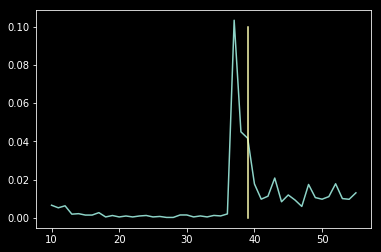

In [215]:
avg = np.average(img)
std = np.std(img)
x = range(10,int((int(img.max())-avg)/std))
y = np.array([len(np.where(img>(avg+(i*std)))[0]) for i in ipb(x)])
plt.plot(x,y)
plt.show()
y = np.log10(y)
y = y[:-1]-y[1:]
n = x[np.where(y==y.max())[0][0]+2]
loc = np.where(img>avg+(n*std))
plt.plot(x[:-1],y)
plt.plot([n,n],[0,0.1])
plt.show()

 [████████████████████████████████████████████████████████████] 99/99 [00:03<00:00, 0.03s/it]

73


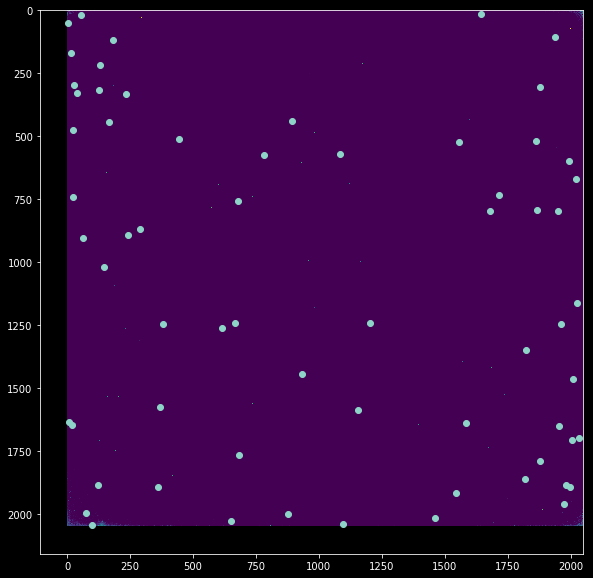

In [175]:
X = range(1,100)
y = np.array([len(np.where(img>(avg+(i*std)))[0]) for i in ipb(X)])
y = np.log10(y)
y = y[:-1]-y[1:]
n = X[np.where(y==y.max())[0][0]+2]
print(n)
loc = np.where(img>avg+(n*std))
plt.figure(figsize=[10,10])
plt.imshow(img)
plt.scatter(loc[0],loc[1])
plt.show()

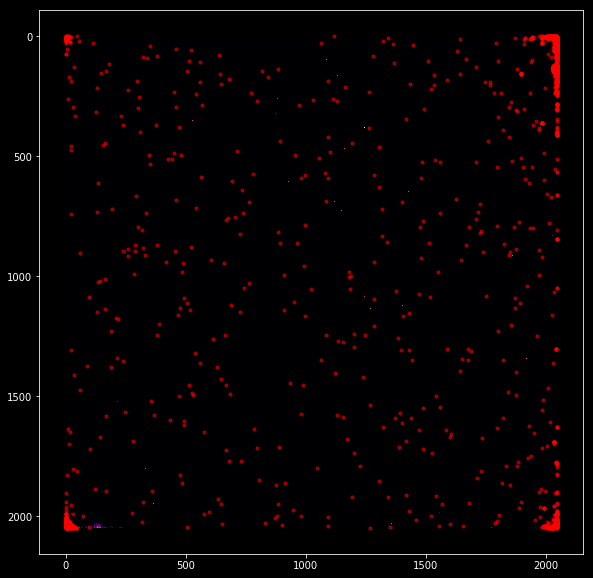

In [144]:
plt.figure(figsize=[10,10])
plt.imshow(img,cmap='inferno')
loc2 = np.where(img>threshold_otsu(img))
plt.scatter(loc2[0],loc2[1],s=10,alpha=0.5,c='r')
plt.show()

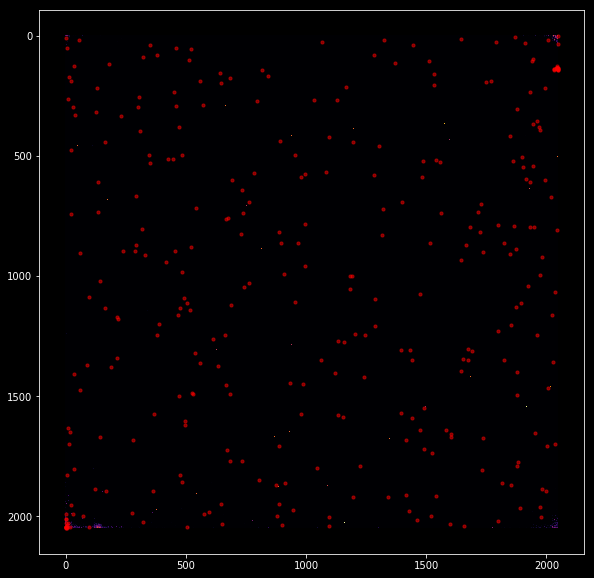

In [147]:
plt.figure(figsize=[10,10])
plt.imshow(img,cmap='inferno')
loc2 = np.where(img>40)
plt.scatter(loc2[0],loc2[1],s=10,alpha=0.5,c='r')
plt.show()

In [146]:
threshold_otsu(img)

11.994140625

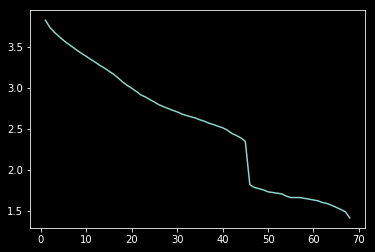

In [134]:
X = range(1,int(np.max(img.ravel())))
y = np.array([len(np.where(img>i)[0]) for i in X])
Y = np.log10(y+1)
plt.plot(X,Y)
plt.show()

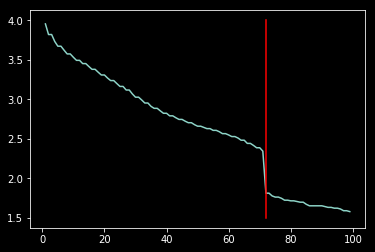

In [172]:
X = range(1,100)
avg = np.average(img)
std = np.std(img)
y = np.array([len(np.where(img>(avg+(i*std)))[0]) for i in X])
Y = np.log10(y)
a = Y[:-1]-Y[1:]
A = np.where(a==a.max())[0][0]+2
plt.plot(X,Y)
plt.plot([A,A],[1.5,4],c='r')
plt.show()

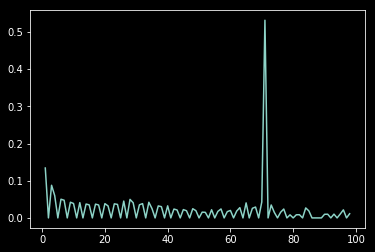

In [161]:
# y = np.log10(np.array(y))
y[:-1]-y[1:]
plt.plot(X[:-1],y[:-1]-y[1:])
plt.show()

In [164]:
a = y[:-1]-y[1:]
np.where(a==a.max())[0][0]

70

In [167]:
len(np.where(img>(avg+(68*std)))[0])

261

In [165]:
len(np.where(img>(avg+(70*std)))[0])

244

In [168]:
len(np.where(img>(avg+(71*std)))[0])

221